<br/>

$$ \huge{\underline{\textbf{ Monte Carlo ES Control }}} $$

<br/>

<img src="assets/0503_MC_ES_Ctrl.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 5.3 </center>

<br/>

In [1]:
def monte_carlo_ES_control(env, ep, gamma):
    """Monte Carlo ES Control
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor
    """
    
    pi = defaultdict(int)        # default action: 0
    Q = defaultdict(float)       # default Q value: 0
    Returns = defaultdict(list)  # dict of lists
    
    for _ in range(ep):
        S0, A0 = env.sample_state_action()
        traj, T = generate_episode_ES(env, pi, S0, A0)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, At = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            if not (St, At) in [(traj[i][0], traj[i][3]) for i in range(0, t)]:
                Returns[(St, At)].append(G)
                Q[(St, At)] = np.average(Returns[(St, At)])
                pi[St] = np.argmax([Q[St,a] for a in range(env.nb_actions)])
                
    return Q, pi

Helper functions:

In [2]:
def generate_episode_ES(env, pi, S0, A0):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:
            St, Rt, done    = env.reset_es(S0), None, False
            At = A0
        else:
            St, Rt, done, _ = env.step(At)
            At = pi[St]
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

---

# Alternative Implementation

TODO comment

In [40]:
def monte_carlo_ES_control_2(env, ep, gamma, callback=None, resume_dicts=None, focus_S0=None):
    """Monte Carlo ES Control
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor
    """
    
    # Change #1: add ability to continue from before
    if resume_dicts is None:
        pi = defaultdict(int)
        C = defaultdict(int)          # Change #2: count number of visits!
        Returns = defaultdict(float)  # Change #3: this is SUM now
        Q = defaultdict(float)        # this is same as before
    else:
        pi, C, Returns, Q = resume_dicts

    for e in range(ep):
        S0, A0 = env.sample_state_action()
        if focus_S0 is not None: S0 = focus_S0
            
        traj, T = generate_episode_ES(env, pi, S0, A0)  # Change #4: replace pi with Q
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, At = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            # Change to every-visit, so we save computation
            C[(St, At)] += 1
            Returns[(St, At)] += G
            Q[(St, At)] = Returns[(St, At)] / C[(St, At)]
            pi[St] = np.argmax([Q[St,a] for a in range(env.nb_actions)])
                
        if callback is not None:
            callback(e, Q)
    
    return Q, pi, (pi, C, Returns, Q)

# Stuff

In [ ]:
def mc_control_inc_BJ(env, N, init_Q=None, init_C=None, callback=None):
    
    if init_C is None:  C = defaultdict(int)
    else:               C = init_C
    
    if init_Q is None:  Q = defaultdict(float)
    else:               Q = init_Q

    for ep in range(N):
        trajectory = generate_episode(env, Q)
        for t in range(len(trajectory)-1):
            Gt = calc_Gt(trajectory, Q, t, 1.0)
            St, _, _, At = trajectory[t]
            C[St, At] += 1
            Q[St, At] = Q[St, At] + (1/C[St, At]) * (Gt - Q[St, At])

        if callback is not None:
            callback(ep, Q)
            
    return Q, C

Helper

In [ ]:
def calc_Gt(trajectory, Q, t, disc, nstep=float('inf')):
    T = len(trajectory)-1   # terminal state
    max_j = min(t+nstep, T) # last state iterated, inclusive
    tmp_disc = 1.0          # this will decay with rate disc
    Gt = 0                  # result

    # Iterate from t+1 to t+nstep or T (inclusive on both start and finish)
    for j in range(t+1, max_j+1):
        Rj = trajectory[j][1]  # traj[j] is (obs, reward, done, action)
        Gt += tmp_disc * Rj
        tmp_disc *= disc

    # Note that Q[Sj, Aj] will have state-value of state t+nstep or
    # zero if t+nstep >= T as V[St=T] must equal 0
    Sj, _, _, Aj = trajectory[j]  # traj[j] is (obs, reward, done, action)
    Gt += tmp_disc * Q[Sj, Aj]
    assert Q[Sj,Aj] == 0

    return Gt

In [ ]:
def generate_episode(env, Q):
    """Generate one complete episode"""
    trajectory = []
    done = True
    for _ in range(1000):  # limit episode length
        # === time step starts ===
        if done:
            init_st, init_at = env.sample_state_action()
            St, Rt, done = env.reset_es(init_st), None, False
            At = init_at
        else:
            St, Rt, done, _ = env.step(At)
            if Q[St,0] == Q[St,1]:
                At = np.random.randint(0, 2)
            else:
                At = np.argmax([Q[St,0], Q[St,1]])
        
        # At = np.random.choice([0, 1], p=policy[St])
        
        trajectory.append((St, Rt, done, At))
        if done:
            break
        # === time step ends here ===
    return trajectory

# Solve Blackjack

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import gym

Extend OpenAI Gym Blackjack-v0 to allow exploring starts

In [8]:
class BlackjackES():
    def __init__(self):
        self._env = gym.make('Blackjack-v0')
        self.nb_actions = 2
        
    def sample_state_action(self):
        """Sample and return valid state & action for exp. starts"""
        player_sum = np.random.randint(12, 22)
        dealer_shows = np.random.randint(1, 11)
        has_ace = np.random.randint(0, 2)
        state = (player_sum, dealer_shows, bool(has_ace))
        action = np.random.randint(0, 2)
        return state, action
        
    def reset_es(self, init_state):        
        """Start game from given state"""
        player_sum, dealer_shows, has_ace = init_state
        assert player_sum in range(12, 22)
        assert dealer_shows in range(1, 11)
        assert isinstance(has_ace, bool)
        
        self._env.reset()  # reset OpenAI env
        
        # draw second card for the dealer
        # according to original probabilities
        dealer_hides = np.random.choice([1, 2, 3, 4, 5, 6, 7,
                                         8, 9, 10, 10, 10, 10])
        
        # override dealer hand
        self._env.dealer = [dealer_shows, dealer_hides]

        # pick cards for player to match player_sum and has_ace
        if has_ace:
            player_hand = [player_sum-11, 1]
        else:
            if player_sum == 21:  player_hand = [10, 9, 2]
            else:                 player_hand = [player_sum-10, 10]
                
        # override player hand
        self._env.player = player_hand
        
        # force re-evaluate observation with new hands
        obs = self._env._get_obs()
        assert obs == init_state
        return obs
    
    def step(self, action):
        return self._env.step(action)
    
#     def step(self, action):
#         obs, reward, done, tmp = self._env.step(action)
#         if done: obs = (-1, -1, False)
#         return obs, reward, done, tmp

Create environment

In [9]:
env = BlackjackES()

Ploting

In [39]:
# def convert_to_arr(V_dict, has_ace):
#     V_dict = defaultdict(lambda: -10, V_dict)  # assume zero if no key
#     V_arr = np.zeros([10, 10])  # Need zero-indexed array for plotting 
    
#     for ps in range(12, 22):     # convert player sum from 12-21 to 0-9
#         for dc in range(1, 11):  # convert dealer card from 1-10 to 0-9
#             V_arr[ps-12, dc-1] = V_dict[(ps, dc, has_ace)]
#     return V_arr



# def plot_3d_wireframe(axis, V_dict, has_ace):
#     Z = convert_to_arr(V_dict, has_ace)
#     dealer_card = list(range(1, 11))
#     player_points = list(range(12, 22))
#     X, Y = np.meshgrid(dealer_card, player_points)
#     axis.plot_wireframe(X, Y, Z)
       
# def plot_blackjack(V_dict):
#     fig = plt.figure(figsize=[16,3])
#     ax_no_ace = fig.add_subplot(121, projection='3d', title='No Ace')
#     ax_has_ace = fig.add_subplot(122, projection='3d', title='With Ace')
#     ax_no_ace.set_xlabel('Dealer Showing'); ax_no_ace.set_ylabel('Player Sum')
#     ax_has_ace.set_xlabel('Dealer Showing'); ax_has_ace.set_ylabel('Player Sum')
#     plot_3d_wireframe(ax_no_ace, V_dict, has_ace=False)
#     plot_3d_wireframe(ax_has_ace, V_dict, has_ace=True)
#     plt.show()

def plot_policy_helper(ax, arr):
    assert arr.shape == (10, 10)
    ax.imshow(arr, origin='lower', vmin=-1, vmax=1, cmap='RdYlGn', alpha=0.3,
          extent=[0.5,10.5,11.5,21.5], interpolation='none');
    ax.set_xticks(np.arange(1,11, 1));
    ax.set_yticks(np.arange(12,22, 1));

def plot_3d_helper(ax, Z):
    assert Z.shape == (10, 10)
    dealer_card = list(range(1, 11))
    player_points = list(range(12, 22))
    X, Y = np.meshgrid(dealer_card, player_points)
    ax.plot_wireframe(X, Y, Z)
    
def plot_blackjack(Q, pi):
    pi_no_ace = np.zeros([10,10])
    pi_has_ace = np.zeros([10,10])
    for ps in range(12, 22):     # convert player sum from 12-21 to 0-9
        for dc in range(1, 11):  # convert dealer card from 1-10 to 0-9
            # store -1 if no data, this should almost never happen
            pi_no_ace[ps-12, dc-1] =  pi[(ps,dc,False)]
            pi_has_ace[ps-12, dc-1] = pi[(ps,dc,True)]
            
    V_has_ace = np.zeros([10,10])
    V_no_ace = np.zeros([10,10])
    for ps in range(12, 22):     # convert player sum from 12-21 to 0-9
        for dc in range(1, 11):  # convert dealer card from 1-10 to 0-9
            # store -1 if no data, this should almost never happen
            V_no_ace[ps-12, dc-1] = Q[((ps,dc,False), pi[(ps,dc,False)])]
            V_has_ace[ps-12, dc-1] = Q[((ps,dc,True), pi[(ps,dc,True)])]
    
    fig = plt.figure(figsize=[8,6])
    fig.text(0., 0.70, 'Usable\n  Ace', fontsize=12)
    fig.text(0., 0.25, '   No\nUsable\n  Ace', fontsize=12)
    
    # Policy, with ace
    ax = plt.subplot2grid([2,3], [0, 0], fig=fig)
    plot_policy_helper(ax, pi_has_ace)
    ax.set_title(r'$\pi_*$', fontsize=24)
    ax.text(8, 20, 'Stick')
    ax.text(8, 13, 'HIT')
    
    # Policy, no ace
    ax = plt.subplot2grid([2,3], [1, 0], fig=fig)
    plot_policy_helper(ax, pi_no_ace)
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.yaxis.set_label_position("right")
    
    # 3d, with ace
    ax = plt.subplot2grid([2,3], [0, 1], colspan=2, fig=fig, projection='3d')
    plot_3d_helper(ax, V_has_ace)
    ax.set_title(r'$v_*$', fontsize=24)
    ax.set_zticks([])
    
    # 3d, no ace
    ax = plt.subplot2grid([2,3], [1, 1], colspan=2, fig=fig, projection='3d')
    plot_3d_helper(ax, V_no_ace)
    ax.set_xlabel('Dealer Showing');
    ax.set_ylabel('Player Sum')
    ax.set_zticks([])
    
    plt.show()

Solve - with 100k episodes we get quick and approximate solution. This will not match te book exactly.

In [10]:
Q, pi = monte_carlo_ES_control(env, ep=100000, gamma=1.0)

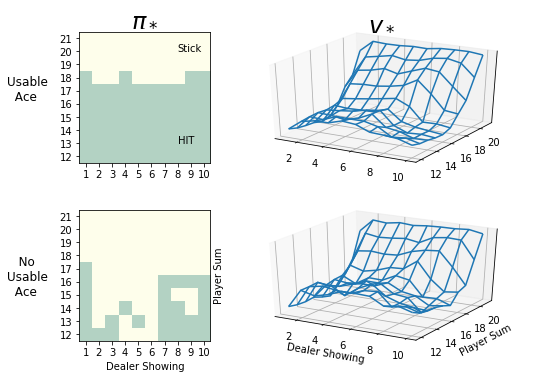

In [38]:
plot_blackjack(Q, pi)

# Variance Analysis

In [291]:
trace = []
def cback(ep, Q):
    if ep % 1000 == 0:
        trace.append(convert_to_sum(Q))
    if ep % 100000 == 0:
        print('ep', ep)

In [7]:
Q = monte_carlo_ES_control(env, ep=100000, gamma=1.0)

AssertionError: 

In [35]:
def convert_to_sum(Q):
    res = np.zeros([10, 10, 2, 2])
    for ps in range(12,22):
        for dc in range(1, 11):
            for ha in [0, 1]:
                for act in [0, 1]:
                    res[ps-12, dc-1, ha, act] = Q[(ps, dc, bool(ha)), act]
    return res

In [17]:
nptr = np.array(trace)
print(len(nptr))

fig = plt.figure(figsize=[12,12])
for ph in range(10):
    for ds in range(10):
        ax=fig.add_subplot(10,10,(((9-ph)*10)+ds)+1)
        #               TR,  ph,ds,ha,  act
        ax.plot( nptr[-1000:, ph,ds,0, 0], color='blue', alpha=1. )
        ax.plot( nptr[-1000:, ph,ds,0, 1], color='red', alpha=1. )
        ax.set_yticks([]); ax.set_xticks([])
    
plt.tight_layout()
plt.show()

NameError: name 'trace' is not defined

In [259]:
trace[100000]

array([[[[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
       

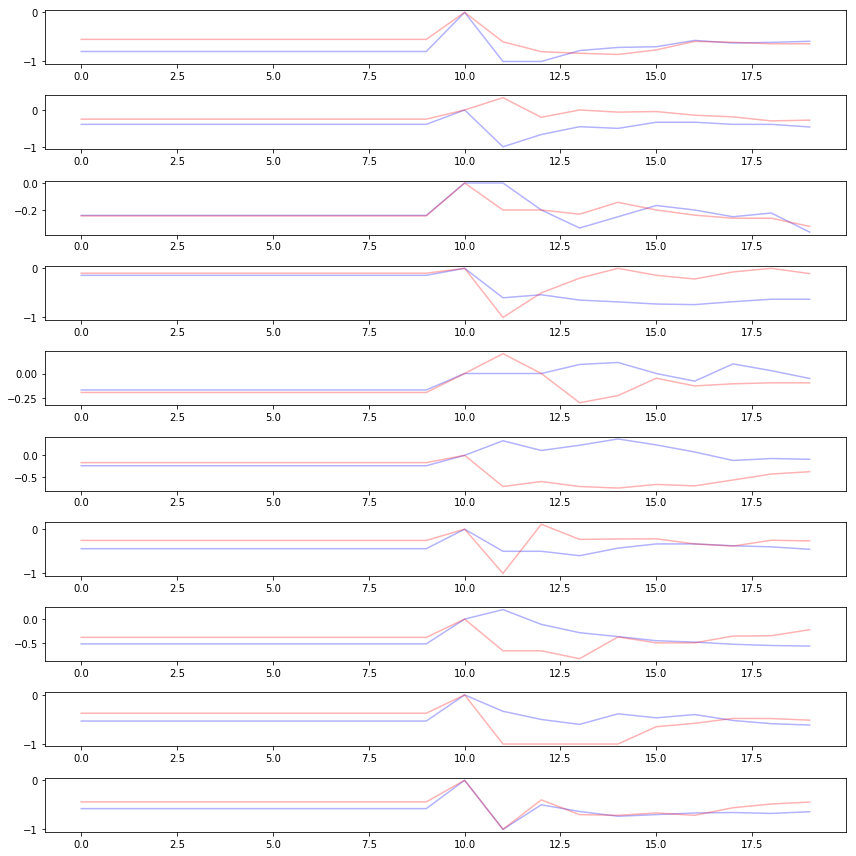

In [250]:
nptr = np.array(trace)

fig = plt.figure(figsize=[12,12])
for i in range(10):
    ax=fig.add_subplot(10,1,i+1)
    #               TR,  ps,dh,ha,  act
    ax.plot( nptr[99990:100010, 0,i,0, 0], color='blue', alpha=0.3 )
    ax.plot( nptr[99990:100010, 0,i,0, 1], color='red', alpha=0.3 )  
plt.tight_layout()

# HAS ACE

7010


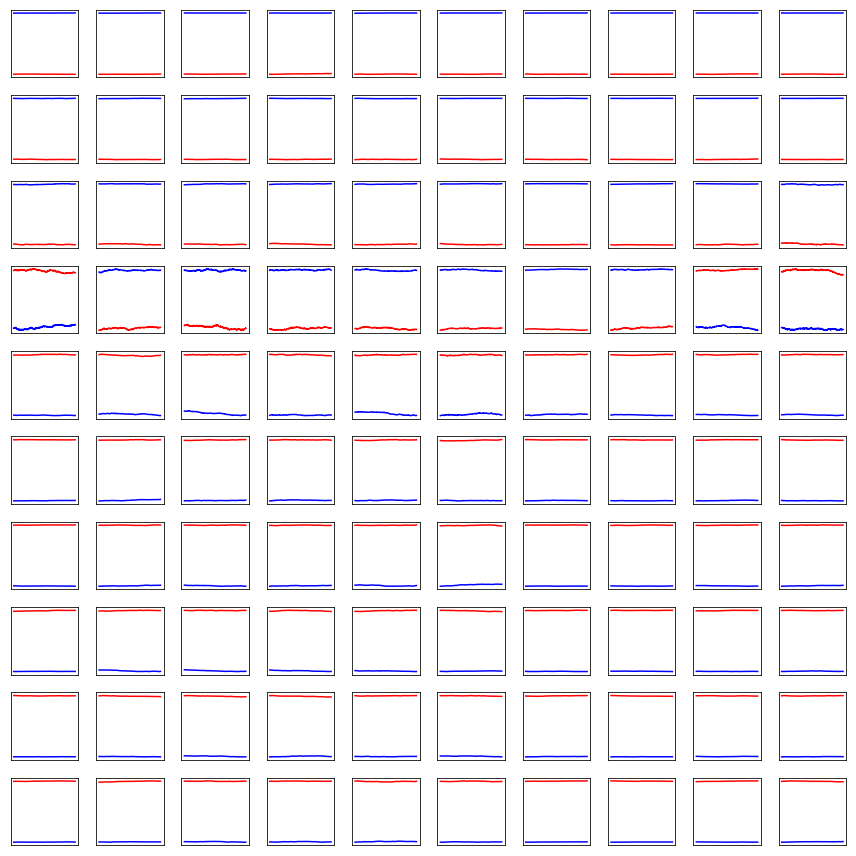

In [169]:
nptr = np.array(trace)
print(len(nptr))

fig = plt.figure(figsize=[12,12])
for ph in range(10):
    for ds in range(10):
        ax=fig.add_subplot(10,10,(((9-ph)*10)+ds)+1)
        #               TR,  ph,ds,ha,  act
        ax.plot( nptr[-1000:, ph,ds,1, 0], color='blue', alpha=1. )
        ax.plot( nptr[-1000:, ph,ds,1, 1], color='red', alpha=1. )
        ax.set_yticks([]); ax.set_xticks([])
    
plt.tight_layout()
plt.show()

# Timing Tests

In [32]:
%timeit -r1 monte_carlo_ES_control(env, ep=10000, gamma=1.0)
%timeit -r1 monte_carlo_ES_control_2(env, ep=10000, gamma=1.0)

1.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [33]:
%timeit -r1 monte_carlo_ES_control(env, ep=100000, gamma=1.0)
%timeit -r1 monte_carlo_ES_control_2(env, ep=100000, gamma=1.0)

14.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [34]:
%timeit -r1 monte_carlo_ES_control(env, ep=1000000, gamma=1.0)
%timeit -r1 monte_carlo_ES_control_2(env, ep=1000000, gamma=1.0)

4min 15s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
